In [5]:
import pandas as pd
import requests
from datetime import datetime
import numpy as np
import collections

# load crime data
url='https://raw.githubusercontent.com/rather-be-hiking/stc510-public/main/crimestat.csv'
crimes=pd.read_csv(url, index_col='INC NUMBER')


In [6]:
# tidy up the columns and make them easier to reference
crimes.rename(columns={"OCCURRED ON":"occured_on", \
                       "OCCURRED TO":"occured_to", \
                       "UCR CRIME CATEGORY":"crime_category", \
                       "100 BLOCK ADDR":"address", \
                       "ZIP":"zip_code", \
                       "PREMISE TYPE":"location_type"}, inplace=True)

# not all crimes are created equal, let's identify violent crimes
crime_type=[]
for index, crime in crimes.iterrows():
    if (crime.crime_category=="MURDER AND NON-NEGLIGENT MANSLAUGHTER") | \
        (crime.crime_category=="RAPE") | \
        (crime.crime_category=="AGGRAVATED ASSAULT"):
        crime_type.append('V')
    else:
        crime_type.append('NV')
crimes['crime_type']=crime_type

# check for a few violent and non-violent to make sure all looks good
crimes[(crimes.crime_category=="MURDER AND NON-NEGLIGENT MANSLAUGHTER") | \
       (crimes.crime_category=="ROBBERY") | \
       (crimes.crime_category=="AGGRAVATED ASSAULT")]

,occured_on,occured_to,crime_category,address,zip_code,location_type,crime_type
INC NUMBER,,,,,,,
201510000015577,11/01/2015 02:00,11/01/2015 06:00,AGGRAVATED ASSAULT,50XX E THOMAS RD,85018.0,RESTAURANT,V
201500002105677,11/01/2015 02:00,11/01/2015 12:00,AGGRAVATED ASSAULT,41XX N 51ST AVE,85031.0,RESTAURANT,V
201500002101067,11/01/2015 04:12,11/01/2015 04:12,MURDER AND NON-NEGLIGENT MANSLAUGHTER,XX N 67TH AVE,85043.0,FENCED COMMERCIAL YARD,V
201500002101137,11/01/2015 04:14,NaN,ROBBERY,138XX S 44TH ST,85044.0,STREET / ROADWAY / ALLEY / SIDEWALK,NV
201500002101372,11/01/2015 06:10,11/01/2015 06:22,AGGRAVATED ASSAULT,42XX N 12TH ST,85014.0,PARKING LOT,V
...,...,...,...,...,...,...,...
201700002024054,11/16/2017 23:50,11/16/2017 23:57,AGGRAVATED ASSAULT,11XX E BUCKEYE RD,85034.0,STREET / ROADWAY / ALLEY / SIDEWALK,V
201700002023906,11/16/2017 23:50,11/16/2017 23:50,ROBBERY,20XX E THUNDERBIRD RD,85022.0,RESTAURANT,NV
201700002030287,11/17/2017 00:00,11/17/2017 00:00,AGGRAVATED ASSAULT,N 19TH AVE & W VOGEL AVE,85021.0,STREET / ROADWAY / ALLEY / SIDEWALK,V


<AxesSubplot:>

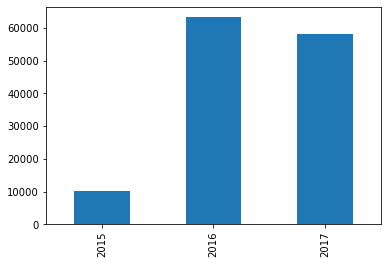

In [7]:
# let's identify case counts by year
def get_year(x):
    if pd.isna(x)!=True:
        return x.year
    else:
        return 'Unknown'

# turn the datetime strings into datetime objects
crimes.occured_on=pd.to_datetime(crimes.occured_on)
crimes.occured_to=pd.to_datetime(crimes.occured_to)

# add a new column for the year
crimes["occured_year"]=crimes.occured_on.apply(lambda x:get_year(x))

# exclude the few that had no occured_on date
yearly_crimes = crimes[(crimes.occured_year!='Unknown')]

# show the sequential annual amounts
yearly_crimes['occured_year'].value_counts().sort_index().plot.bar()

<AxesSubplot:xlabel='occured_year'>

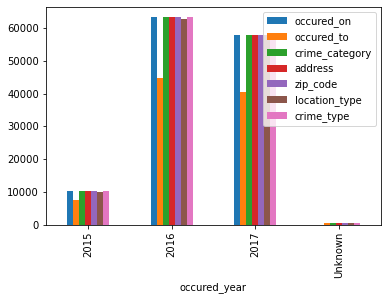

In [8]:
# this is a visual quality check that quickly shows:
#   occured_to is often missing values
#   location_type is ommitted occasionally
#   some had no occured_on date (the 'Unknown')
qual_check = crimes.groupby(by='occured_year').count()
qual_check.plot.bar()

In [10]:
# let's see where the high crme zip codes are by crime volume alone

# prepare our registry of zip codes
zip_crimes_list = crimes.zip_code.unique()
zip_crimes_list_t = []
for zip_entry in zip_crimes_list:
    if pd.isna(zip_entry)==False:
        zip_crimes_list_t.append(str(int(zip_entry)))

# set up a dictionary to associate zips and crime volume
zip_crimes = dict.fromkeys(zip_crimes_list_t,0)

# establish crime volume
for index, crime in crimes.iterrows():
    if pd.isna(crime['zip_code'])==False:
        key = str(int(crime['zip_code']))
        zip_crimes[key]+=1

# order the zip codes by greatest crime volume to least
ordered_zip_crime_volume = sorted(zip_crimes.items(), key=lambda x:x[1], reverse=True)

# gather the top zip codes by incdent count
zip_dict = {}
for i in range(35):
    # gather attribute data
    zip_int      = int(ordered_zip_crime_volume[i][0])
    crime_volume = ordered_zip_crime_volume[i][1]
    
    # load data into our prepared dictionary
    zip_dict[ordered_zip_crime_volume[i][0]]= pd.Series([crime_volume], \
                       index =['Crime Volume'])

# use the dictionary to create a dataframe
df = pd.DataFrame(zip_dict)
df = df.transpose()
df

,Crime Volume
85015,6963
85008,6320
85009,5513
85041,5477
85051,5389
85017,5355
85035,4752
85043,4330
85032,4301
85033,4258


<AxesSubplot:title={'center':'Crime Distribution'}>

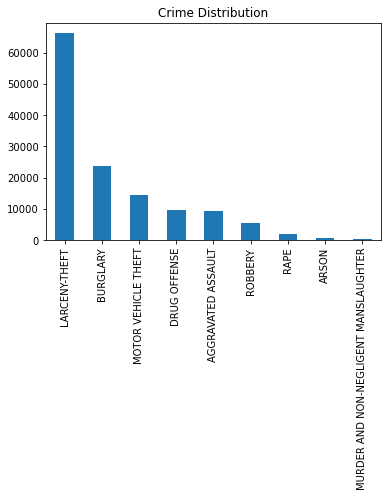

In [11]:
# case counts by crime category - nice to see that low murder bar
crimes.crime_category.value_counts().plot.bar(title='Crime Distribution')

<AxesSubplot:title={'center':'Deadliest Zip Code?'}>

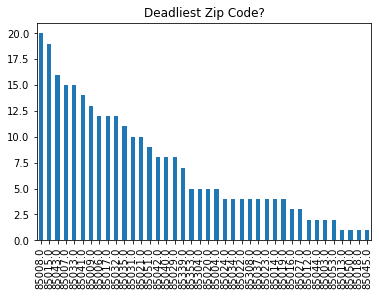

In [13]:
# where is murder and manslaughter occuring?
crimes[(crimes.crime_category=="MURDER AND NON-NEGLIGENT MANSLAUGHTER") \
      ].zip_code.value_counts().plot.bar(title='Deadliest Zip Code?')

<AxesSubplot:title={'center':'Murder Trend for 85008'}>

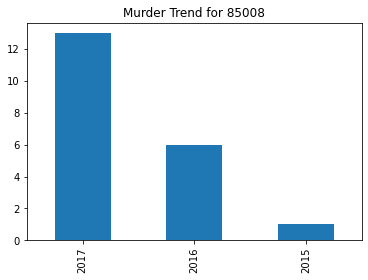

In [15]:
# is this murder habit growing or shrinking for 85008?
crimes[(crimes.crime_category=="MURDER AND NON-NEGLIGENT MANSLAUGHTER") & (crimes.zip_code==85008) \
      ].occured_year.value_counts().plot.bar(title='Murder Trend for 85008')

# YIKES!

In [16]:
#let's save off our crimes data and descriptive top crime zips data frame
crimes.to_csv('basic_modified_crimes_data.csv')
df.to_csv('basic_top_crime_zips.csv')